In [7]:
import tensorflow as tf
import numpy as np
import time

In [2]:
verbose=False

In [3]:
def distance(data, name="distances"):
    return tf.map_fn(lambda A: tf.map_fn(lambda B: tf.norm(A-B), data), data, name = name)

In [4]:
def get_linkage(first, second, name="linkage"):
    return tf.reduce_mean([first, second], axis=0, name=name)

In [5]:
def drop_row(data, row=tf.constant(0, dtype=tf.int64), name="drop_row"):
    return tf.concat([tf.slice(data,[tf.constant(0, dtype=tf.int64),0],[row,-1]),tf.slice(data,[row+tf.constant(1, dtype=tf.int64),0],[-1,-1])], axis=0, name=name)

# Init 

In [28]:
data_list = [[1,2,10],[1,2,4],[1,2,3],[1,3,6],[3,4,8],[1,3,7]]

In [29]:
tf.reset_default_graph()
data = tf.constant(data_list, dtype=tf.float64, name="data")
new_data = tf.Variable(data, name = "data_variable")##variable should change shape
npoints = data.shape[0].value
steps = npoints
n_max_clusters = npoints ##max number
n_actual_clusters = npoints ##currently considered
assignments = np.linspace(0.,npoints-1,npoints)
sizes = np.ones_like(assignments)
orig_shape = data.shape[0]
Z = []
init = tf.global_variables_initializer()

# Run

In [30]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("graph/", sess.graph)
    sess.run(init)
    start=time.time()
    for i in range(steps-1):
        print("step",i)
        distances = distance(new_data)
        n = distances.shape[0]
        ##remove diagonal
        nddistances = tf.reshape(tf.boolean_mask(distances,tf.logical_not(tf.equal(distances,tf.zeros_like(distances)))),(n,n-1))#1 is diagonal
        actual_minimums = tf.sort(tf.sort(tf.where(tf.equal(tf.reduce_min(nddistances),distances)), axis=1), axis=0, name="assignemts")[0]
        original_cluster_indexes = tf.gather(assignments, tf.cast(actual_minimums, tf.int64), name="correct_assignemts")
        if verbose:
            print("merging..",original_cluster_indexes.eval())
        min_distance = tf.cast(distances[actual_minimums[0]][actual_minimums[1]], tf.float64, name="minimum_distance")
        ##mean position of new cluster
        new_pos = get_linkage(new_data[actual_minimums[0]],new_data[actual_minimums[1]], name="linkage")
        assignments=np.delete(assignments,actual_minimums.eval())
        n_actual_clusters-=2
        data=tf.concat([data,[new_pos]], axis=0)
        assignments = np.concatenate([assignments, [n_max_clusters]], axis=0)##new cluster
        current_size=np.sum(sizes[np.array(original_cluster_indexes.eval()).astype(int)])
        sizes = np.concatenate([sizes, [current_size]])
        n_actual_clusters+=1
        if verbose:
            print("current clusters..",assignments)
            print("current sizes..", sizes)
        new_data = tf.Variable(tf.zeros((n_actual_clusters,data.shape[1]), dtype=tf.float64), dtype=tf.float64)
        tf.assign(new_data,tf.gather(data, tf.cast(assignments,tf.int64)), validate_shape=False).eval()
        #new_data = tf.reshape(new_data, (n_actual_clusters,data.shape[1]))
        if verbose:
            print("data..",new_data.eval()," with shape..", new_data.shape)
        n_max_clusters = n_max_clusters+1
        Z.append(tf.stack([original_cluster_indexes[0], original_cluster_indexes[1], min_distance, current_size],0).eval())
    Z=np.array(Z).astype(float)
    print("Z..",Z)
print("runed in..",time.time()-start," seconds")
writer.close()

step 0
step 1
step 2
step 3
step 4
Z.. [[1.         2.         1.         2.        ]
 [3.         5.         1.         2.        ]
 [4.         7.         2.6925824  3.        ]
 [0.         8.         3.28823661 4.        ]
 [6.         9.         5.20366457 6.        ]]
runed in.. 27.624793767929077  seconds


# Compare

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [32]:
Zpy = linkage(data_list)
Zpy

array([[3.        , 5.        , 1.        , 2.        ],
       [1.        , 2.        , 1.        , 2.        ],
       [6.        , 7.        , 2.23606798, 4.        ],
       [4.        , 8.        , 2.44948974, 5.        ],
       [0.        , 9.        , 3.16227766, 6.        ]])

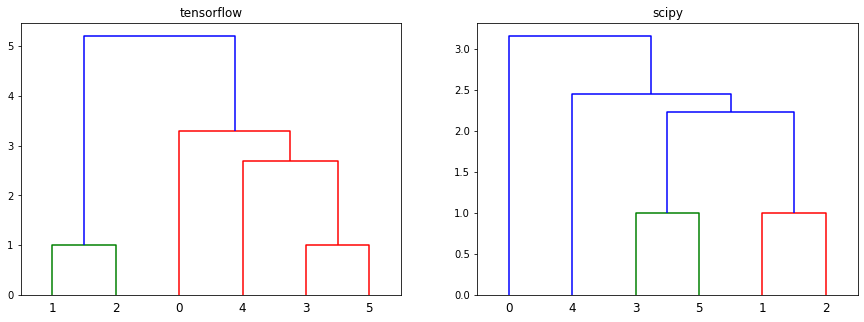

In [33]:
fig = plt.figure(figsize=(15,5))
ax = fig.subplots(1,2)
ax[0].set_title("tensorflow")
dendrogram(Z,ax=ax[0])
ax[1].set_title("scipy")
dendrogram(Zpy, ax = ax[1])
plt.show()

In [34]:
model = AgglomerativeClustering()
model.fit_predict(data_list)

array([0, 1, 1, 0, 0, 0])

In [35]:
fcluster(Z, t=0.8)

array([2, 1, 1, 2, 2, 2], dtype=int32)